In [1]:
!pip install git+https://github.com/ncullen93/torchsample

  Cloning https://github.com/ncullen93/torchsample to /tmp/pip-req-build-r476fi7d
  Running command git clone -q https://github.com/ncullen93/torchsample /tmp/pip-req-build-r476fi7d
  Created wheel for torchsample: filename=torchsample-0.1.3-cp37-none-any.whl size=43416 sha256=bb5753cb2dc26c5ee8918fafee0b0fa203bf0b484567fa8ec2aeb45fe8348bba
  Stored in directory: /tmp/pip-ephem-wheel-cache-s5obi1ye/wheels/88/c7/72/14cd9a173eed1e29d0b17d866e7d9ee511d31a834aedd27489
Successfully built torchsample


In [2]:
# Import libraries and modules
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchsummary as summary
from torchsample.modules import ModuleTrainer
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.transforms import Compose 
from torchsample.callbacks import EarlyStopping
from torch.nn import Linear, Conv2d, MaxPool2d, AvgPool2d
from torch.nn import ReLU, Softmax, BatchNorm2d, Dropout, Flatten

import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Define data augmentation
train_transform = Compose([
        transforms.GaussianBlur(kernel_size=15, sigma=(0.01,0.2)),
        transforms.ColorJitter(brightness=0.1, saturation=0.1, hue=0.1), 
        transforms.RandomAffine(degrees=15, scale=(0.9,1.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=0.131, std=0.3085)
    ])

test_transform = Compose([
    transforms.ToTensor()
])

# Load MNIST training and testing Dataset objects
train_dataset = datasets.MNIST('./data', train=True, download=True,  # Downloads into a directory ../data
                               transform=train_transform)
# Take random subset of training data
sample_size = len(train_dataset)//1
train_dataset, unused_train_dataset = torch.utils.data.random_split(train_dataset, [sample_size, len(train_dataset)-sample_size])

train_dataset_untransformed = datasets.MNIST('./data', train=True, download=True,  # Downloads into a directory ../data
                               transform=test_transform)
test_dataset = datasets.MNIST('./data', train=False, download=False,  # No need to download again
                              transform=test_transform)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


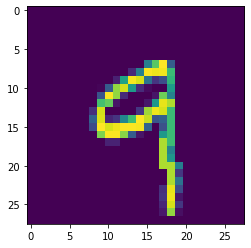

In [ ]:
# Visualize data augmentation
import random
plt.imshow(train_dataset[random.randint(0, len(train_dataset))][0][0].numpy())

In [4]:
# Define training variables
batch_size = 128
test_batch_size = 128
epochs = 10
lr=1.0
step=1
gamma=0.7
log_interval=10

In [5]:
# Create a validation set by sampling 15% of each digit class from training dataset
subset_indices_train = []
subset_indices_valid = []
labels = [train_dataset[row][1] for row in range(len(train_dataset))]
for digit in range(0, 10):
    indices = list(filter(lambda x: labels[x] == digit, range(len(labels))))
    # randomly sample 15% for validation, rest for train
    random.shuffle(indices)
    split = int(0.15*len(indices))
    subset_indices_valid.extend(indices[:split])
    subset_indices_train.extend(indices[split:])

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size,
    sampler=SubsetRandomSampler(subset_indices_train)
)
val_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=test_batch_size,
    sampler=SubsetRandomSampler(subset_indices_valid)
)

In [6]:
# Define training and testing
def train(model, device, train_loader, optimizer, epoch):
    '''
    This is your training function. When you call this function, the model is
    trained for 1 epoch.
    '''
    model.train()   # Set the model to training mode
    total = 0
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()               # Clear the gradient
        output = model(data)                # Make predictions
        loss = F.nll_loss(output, target)   # Compute loss
        train_loss += F.nll_loss(output, target, reduction='sum').item()
        loss.backward()                     # Gradient computation
        optimizer.step()                    # Perform a single optimization step
        # Compute accuracy
        pred = output.argmax(dim=1, keepdim=True) # Predictions with max log-probability
        total += len(data)
        correct += pred.eq(target.view_as(pred)).sum().item()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.sampler),
                100. * batch_idx / len(train_loader), loss.item(),
                100. * correct / total))
    train_loss /= total
    accuracy = 100. * correct / total
    print("Train Set Accuracy: ", accuracy)
    return accuracy, loss

def test(model, device, test_loader):
    model.eval()    # Set the model to inference mode
    test_loss = 0
    correct = 0
    test_num = 0
    with torch.no_grad():   # For the inference step, gradient is not computed
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            test_num += len(data)

    test_loss /= test_num
    accuracy = 100. * correct / test_num
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, test_num, accuracy))
    
    return accuracy, test_loss

In [7]:
# Define Models

class fcNet(nn.Module):
    '''
    Design your model with fully connected layers (convolutional layers are not
    allowed here). Initial model is designed to have a poor performance. These
    are the sample units you can try:
        Linear, Dropout, activation layers (ReLU, softmax)
    '''
    def __init__(self):
        # Define the units that you will use in your model
        # Note that this has nothing to do with the order in which operations
        # are applied - that is defined in the forward function below.
        super(fcNet, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=20)
        self.fc2 = nn.Linear(20, 10)
        self.dropout1 = nn.Dropout(p=0.5)

    def forward(self, x):
        # Define the sequence of operations your model will apply to an input x
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = F.relu(x)

        output = F.log_softmax(x, dim=1)
        return output

# Default model
class ConvNet(nn.Module):
    '''
    Design your model with convolutional layers.
    '''
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3), stride=1)
        self.conv2 = nn.Conv2d(8, 8, 3, 1)
        self.dropout1 = nn.Dropout2d(0.5)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(200, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        # input shape = (1, 28, 28)
        x = self.conv1(x) # [(28−3)/1]+1 --> 26x26x8
        x = F.relu(x)
        x = F.max_pool2d(x, 2) # 26 / 2 --> 13x13x8
        x = self.dropout1(x)

        x = self.conv2(x) # [(13-3)/1]+1 --> 11x11x8
        x = F.relu(x)
        x = F.max_pool2d(x, 2) # 11/2 --> 5x5x8
        x = self.dropout2(x)

        x = torch.flatten(x, 1) # 5x5x8 --> 200
        x = self.fc1(x) # 200 --> 64
        x = F.relu(x)
        x = self.fc2(x) # 64 --> 10

        output = F.log_softmax(x, dim=1)
        return output

''' Pytorch implementation of VGG16 network, which is very deep.'''
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.conv1 = nn.Sequential (
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(0.5),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.5)
        )
        self.conv2 = nn.Sequential (
            nn.Conv2d(64, 128, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(0.5),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.5)
        )
        self.conv3 = nn.Sequential (
            nn.Conv2d(128, 512, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(0.5),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.5)
        )
        self.conv4 = nn.Sequential (
            nn.Conv2d(512, 512, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(0.5),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.5)
        )
        self.fc1 = nn.Linear(512, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 1000)

    def forward(self, x):
        # input shape = (1, 28, 28)
        x = self.conv1(x) # [(28−3)/1]+1 --> 6x6x32
        x = self.conv2(x) # [(13-3)/1]+1 --> 11x11x32
        x = self.conv3(x)
        x = self.conv4(x)

        x = torch.flatten(x, 1) # 5x5x32 --> 800
        x = self.fc1(x) # 200 --> 64
        x = F.relu(x)
        x = self.fc2(x) # 64 --> 10

        output = F.log_softmax(x, dim=1)
        return output

# My Convolutional Neural Network (CNN) Model
# Define Model using only...
# Linear, Conv2d, MaxPool2d, AvgPool2d, ReLU, Softmax, BatchNorm2d, Dropout, Flatten
class Net(nn.Module):
    '''
    Build the best MNIST classifier.
    '''
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential (
            nn.Conv2d(in_channels=1, out_channels=128, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(0.5),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.5)
        )
        self.conv2 = nn.Sequential (
            nn.Conv2d(128, 128, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(0.5),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.5)
        )
        self.conv3 = nn.Sequential (
            nn.Conv2d(128, 1028, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(1028),
            nn.Conv2d(1028, 1028, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(1028),
            nn.ReLU(0.5),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.5)
        )

        self.fc1 = nn.Linear(1028*3*3, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 1000)

    def forward(self, x):
        # input shape = (1, 28, 28)
        x = self.conv1(x) # [(28−3)/1]+1 --> 6x6x32
        x = self.conv2(x) # [(13-3)/1]+1 --> 11x11x32
        x = self.conv3(x)
        #x = self.conv4(x)

        x = torch.flatten(x, 1) # 5x5x32 --> 800
        x = self.fc1(x) # 200 --> 64
        x = F.relu(x)
        x = self.fc2(x) # 64 --> 10

        output = F.log_softmax(x, dim=1)
        return output


In [8]:
''' Implementation from https://github.com/JayPatwardhan/ResNet-PyTorch/blob/master/ResNet/ResNet.py '''
import torch
import torch.nn as nn
import torch.nn.functional as F

class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)
        
        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
       
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
      identity = x.clone()

      x = self.relu(self.batch_norm2(self.conv1(x)))
      x = self.batch_norm2(self.conv2(x))

      if self.i_downsample is not None:
          identity = self.i_downsample(identity)
      print(x.shape)
      print(identity.shape)
      x += identity
      x = self.relu(x)
      return x
 
class ResNet50(nn.Module):
    def __init__(self, ResBlock, num_classes, num_channels=3):
        super(ResNet50, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, 3, planes=64)
        self.layer2 = self._make_layer(ResBlock, 4, planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, 6, planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, 3, planes=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)
    

In [9]:
# Define model and print model summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Default ConvNet()
#model = ConvNet().to(device) # ConvNet() default
#lr = 1
#optimizer = optim.Adadelta(model.parameters(), lr=lr)

# VGG16 
#model = VGG16().to(device)
#lr = 0.001
#optimizer = optim.Adam(model.parameters(), lr=lr)

# ResNet50
#model = ResNet50(Bottleneck, num_classes=10, num_channels=1).to(device)
#lr = 0.001
#optimizer = optim.Adamax(model.parameters(), lr=lr)

# Custom Model
model = Net().to(device)
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)

print("Model Summary:")
summary.summary(model, (1, 28, 28))

Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 28, 28]           1,280
       BatchNorm2d-2          [-1, 128, 28, 28]             256
            Conv2d-3          [-1, 128, 28, 28]         147,584
       BatchNorm2d-4          [-1, 128, 28, 28]             256
              ReLU-5          [-1, 128, 28, 28]               0
         MaxPool2d-6          [-1, 128, 14, 14]               0
           Dropout-7          [-1, 128, 14, 14]               0
            Conv2d-8          [-1, 128, 14, 14]         147,584
       BatchNorm2d-9          [-1, 128, 14, 14]             256
           Conv2d-10          [-1, 128, 14, 14]         147,584
      BatchNorm2d-11          [-1, 128, 14, 14]             256
             ReLU-12          [-1, 128, 14, 14]               0
        MaxPool2d-13            [-1, 128, 7, 7]               0
          Dropout-14    

In [10]:
# Set your learning rate scheduler
scheduler = StepLR(optimizer, step_size=step, gamma=gamma)

# Training loop
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
prev_val_loss = 0
for epoch in range(1, epochs + 1):
    acc, loss = train(model, device, train_loader, optimizer, epoch)
    train_acc.append(acc)
    train_loss.append(loss)
    acc, loss = test(model, device, val_loader)
    valid_acc.append(acc)
    valid_loss.append(loss)
    #if epoch > 3 and loss < prev_val_loss:
    #  break
    prev_val_loss = loss
    scheduler.step()    # learning rate scheduler

    # You may optionally save your model at each epoch here


Train Epoch: 1 [0/51005 (0%)]	Loss: 8.434336	Accuracy: 0.000000
Train Epoch: 1 [1280/51005 (3%)]	Loss: 7.765247	Accuracy: 10.866477
Train Epoch: 1 [2560/51005 (5%)]	Loss: 3.787027	Accuracy: 13.318452
Train Epoch: 1 [3840/51005 (8%)]	Loss: 1.924505	Accuracy: 15.700605
Train Epoch: 1 [5120/51005 (10%)]	Loss: 1.488327	Accuracy: 21.570122
Train Epoch: 1 [6400/51005 (13%)]	Loss: 1.085057	Accuracy: 27.941176
Train Epoch: 1 [7680/51005 (15%)]	Loss: 0.809530	Accuracy: 34.336578
Train Epoch: 1 [8960/51005 (18%)]	Loss: 0.567380	Accuracy: 40.426937
Train Epoch: 1 [10240/51005 (20%)]	Loss: 0.420068	Accuracy: 45.650077
Train Epoch: 1 [11520/51005 (23%)]	Loss: 0.378638	Accuracy: 49.939904
Train Epoch: 1 [12800/51005 (25%)]	Loss: 0.507765	Accuracy: 53.681931
Train Epoch: 1 [14080/51005 (28%)]	Loss: 0.255019	Accuracy: 56.756757
Train Epoch: 1 [15360/51005 (30%)]	Loss: 0.347665	Accuracy: 59.394370
Train Epoch: 1 [16640/51005 (33%)]	Loss: 0.304437	Accuracy: 61.754532
Train Epoch: 1 [17920/51005 (35%)]	L

In [ ]:
torch.save(model.state_dict(), "mnist_model_0.0625.pt")

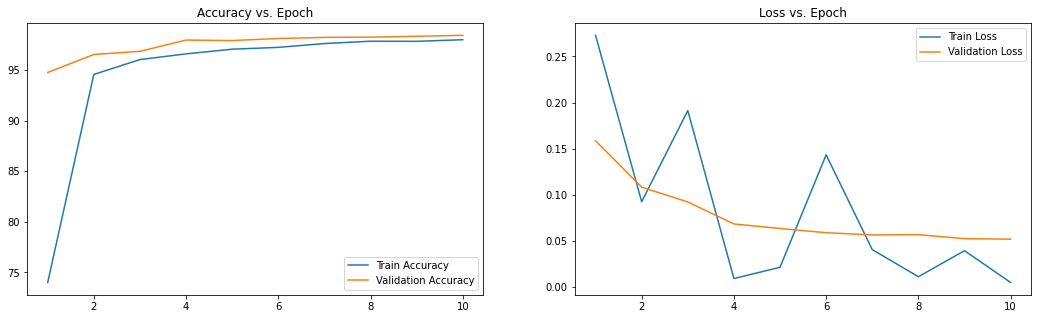

In [ ]:
# Plot loss and accuracy curves
fig, (ax1, ax2) = plt.subplots(figsize=(18, 5), ncols=2)
ax1.plot(range(1, len(train_acc) + 1), train_acc, label='Train Accuracy')
ax1.plot(range(1, len(valid_acc) + 1), valid_acc, label='Validation Accuracy')
ax1.legend()
ax1.set_title('Accuracy vs. Epoch')
ax2.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss')
ax2.plot(range(1, len(valid_loss) + 1), valid_loss, label='Validation Loss')
ax2.legend()
ax2.set_title('Loss vs. Epoch')
plt.show()

## Evalutate Model on Test Set

In [11]:
def test(model, device, test_loader):
    model.eval()    # Set the model to inference mode
    test_loss = 0
    correct = 0
    test_num = 0
    with torch.no_grad():   # For the inference step, gradient is not computed
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            test_num += len(data)

    test_loss /= test_num
    accuracy = 100. * correct / test_num
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, test_num, accuracy))
    
    return accuracy, test_loss

In [12]:
# Evaluate on the official test set
#model = Net().to(device)
#model.load_state_dict(torch.load('/content/mnist_model_best.pt'))

test_dataset = datasets.MNIST('./data', train=False,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ]), download=True)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=test_batch_size, shuffle=True)

test(model, device, test_loader)


Test set: Average loss: 0.0178, Accuracy: 9934/10000 (99%)



(99.34, 0.017811098368093373)

## Plot Train and Test Error vs. Number of Training Examples

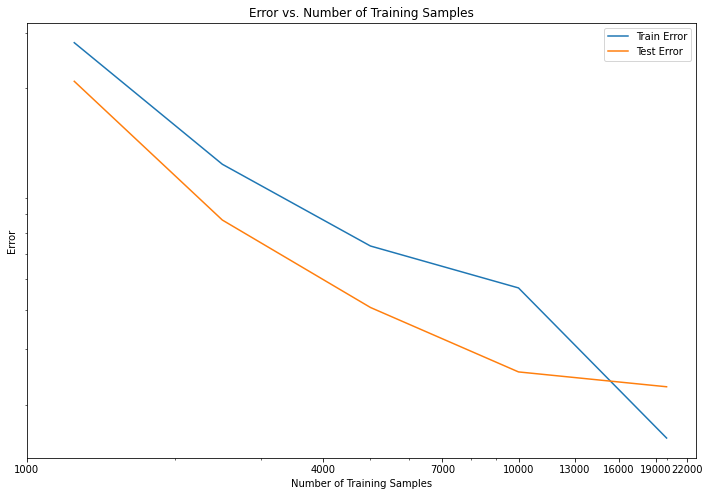

In [ ]:
x_labels = [20000*frac for frac in [1, 0.5, 0.25, 0.125, 0.0625]] # Number of training examples
train_err = [0.0157, 0.0468, 0.0635, 0.1151, 0.2788]
test_err = [0.0228, 0.0254, 0.0406, 0.0767, 0.2105]

fig, ax = plt.subplots(figsize=(12,8))
plt.loglog(x_labels, train_err, label='Train Error')
plt.loglog(x_labels, test_err, label='Test Error')
plt.legend()
plt.xlabel('Number of Training Samples')
ax.set_xticks(np.arange(1000, 23000, 3000))
ax.set_xticklabels(np.arange(1000, 23000, 3000))
plt.ylabel('Error')
plt.yticks(np.arange(0, 1, 10))
plt.title('Error vs. Number of Training Samples')
plt.show()

## Show examples of correct and incorrect detections

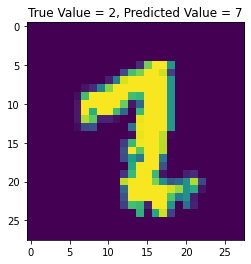

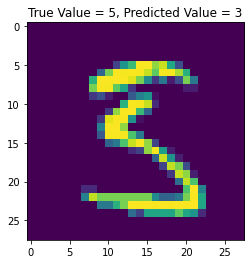

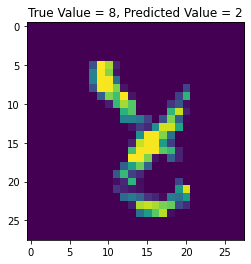

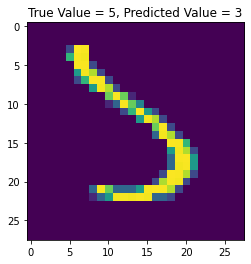

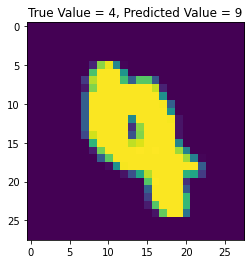

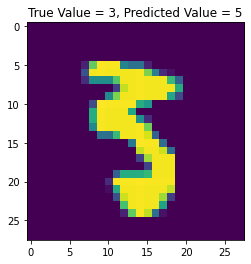

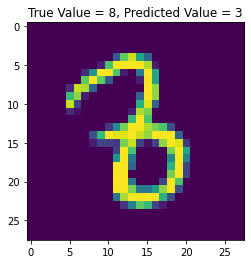

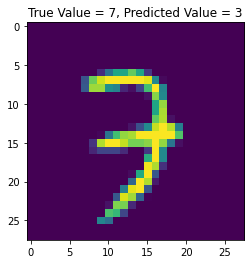

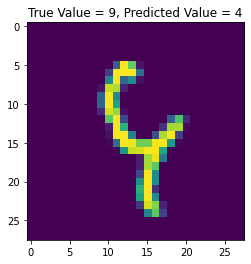

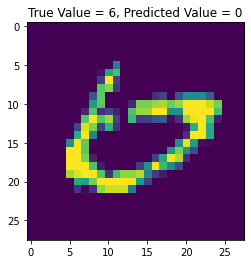

In [41]:
count_incorrect = 0

with torch.no_grad():
    for data, targets in test_loader:
      if count_incorrect >= 10:
          break
      data, targets = data.to(device), targets.to(device)
      output = model(data)
      preds = output.argmax(dim=1, keepdim=True)
      for i in range(len(preds)):
        pred, target = preds[i], targets[i]
        if pred != target:
            count_incorrect += 1
            # Show incorrect prediction
            plt.imshow(data[i][0].cpu().data)
            target_label = str(target.cpu().data.numpy())
            pred_label = str(pred.cpu().data.numpy()[0])
            plt.title("True Value = "+target_label+", Predicted Value = "+pred_label)
            plt.show()

## Confusion Matrix

In [83]:
from sklearn.metrics import confusion_matrix

imgs = []
true_labels = []
pred_labels = []
with torch.no_grad():   # For the inference step, gradient is not computed
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        
        true_labels.extend(list(target.cpu().data.numpy()))
        pred_labels.extend(list(pred.cpu().data.numpy()))
        imgs.extend(list(data.cpu().data.numpy()))

confusion_matrix(true_labels, pred_labels, labels=range(0, 10))       

array([[ 978,    0,    0,    0,    0,    0,    1,    1,    0,    0],
       [   0, 1133,    0,    0,    0,    0,    1,    1,    0,    0],
       [   1,    0, 1026,    0,    0,    0,    0,    5,    0,    0],
       [   0,    0,    2, 1004,    0,    4,    0,    0,    0,    0],
       [   0,    0,    0,    0,  976,    0,    0,    0,    0,    6],
       [   1,    0,    0,    6,    0,  884,    1,    0,    0,    0],
       [   3,    3,    0,    0,    2,    0,  949,    0,    1,    0],
       [   0,    2,    2,    1,    0,    0,    0, 1023,    0,    0],
       [   2,    1,    3,    1,    0,    0,    1,    1,  961,    4],
       [   0,    0,    0,    0,    5,    2,    0,    1,    1, 1000]])

## tSNE

In [84]:
from sklearn.manifold import TSNE
imgs_reshape = np.reshape(np.array(imgs), (len(imgs), 28*28))
print(np.array(imgs_reshape).shape)
print(np.array(pred_labels).shape)
#features = np.concatenate(imgs_reshape, pred_labels)
tsne = TSNE(n_components=2).fit_transform(imgs_reshape)
print(np.array(tsne).shape)

(10000, 784)
(10000, 1)
(10000, 2)


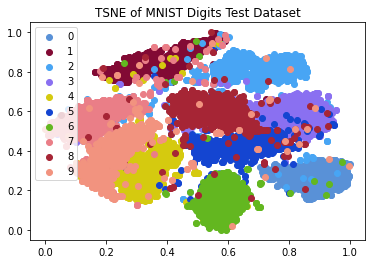

In [85]:
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

# initialize a matplotlib plot
fig = plt.figure()
ax = fig.add_subplot(111)

def random_color():
    rgbl=[255,0,0]
    random.shuffle(rgbl)
    return rgbl

# for every class, we'll add a scatter plot separately
for label in range(0, 10):
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(true_labels) if l == label]

    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)

    # convert the class color to matplotlib format
    rgb = (random.random(), random.random(), random.random())

    # add a scatter plot with the corresponding color and label
    ax.scatter(current_tx, current_ty, c=[rgb], label=label)

# build a legend using the labels we set previously
ax.legend(loc='best')

# finally, show the plot
plt.title('TSNE of MNIST Digits Test Dataset')
plt.show()

## Similar Test Images

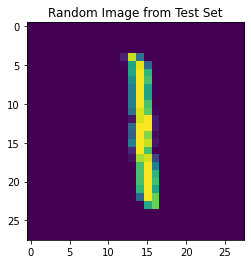

0.13665678
0.19308138
0.42875522
0.6186228
1.1414397
1.2138646
1.3096248
1.799321


<Figure size 432x288 with 0 Axes>

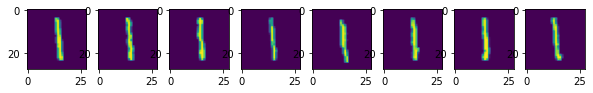

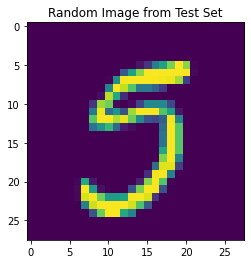

0.39831606
0.887127
1.1280344
1.2693512
1.3531725
1.4819304
1.606572
1.8540897


<Figure size 432x288 with 0 Axes>

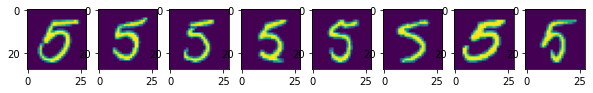

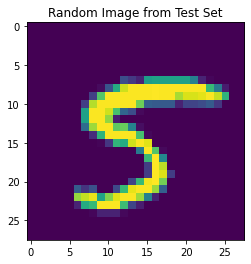

0.063392185
1.3304137
1.3560458
1.3672861
1.3840507
1.4376606
1.5745113
1.5914142


<Figure size 432x288 with 0 Axes>

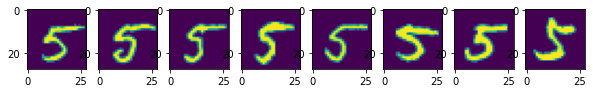

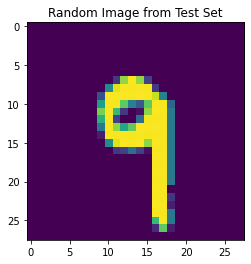

0.20013374
0.47308657
0.47935876
0.7165198
1.0132235
1.4943086
1.6186615
1.7129169


<Figure size 432x288 with 0 Axes>

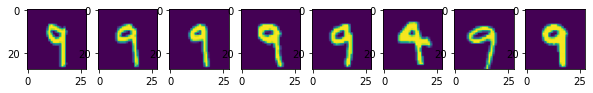

<Figure size 432x288 with 0 Axes>

In [90]:
from sklearn.metrics.pairwise import euclidean_distances
n = 4
for i in range(n):
    rand_idx = random.randint(0, len(imgs))
    target_img = imgs[rand_idx]
    target_coords = tsne[rand_idx]

    plt.imshow(np.reshape(target_img, (28, 28)))
    plt.title("Random Image from Test Set")
    plt.show()
    plt.savefig('target' + str(i) +'.png')

    # Get closest images by coordinates
    distances = euclidean_distances(tsne, [target_coords])
    zipped = zip(distances.flatten(), imgs)
    sorted_pairs = sorted(list(zipped), key = lambda x: x[0])
    tuples = zip(*sorted_pairs)
    distances, closest_imgs = [ list(t) for t in tuples]

    fig, axs = plt.subplots(figsize=(10, 6), ncols=8)
    for i in range(len(axs)):
      axs[i].imshow(np.reshape(closest_imgs[i+1], (28,28))) # +1 in order to skip itself with distance 0
      print(distances[i+1])
    #plt.title("Closest Images", y=1.08)
    plt.show()
    plt.savefig('closest' + str(i) +'.png')
      